In [1]:
#240

In [2]:
# 基础运算库
import numpy as np
import pandas as pd
import pickle
import gc
# 深度学习库
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dropout, Flatten, Dense, LeakyReLU, BatchNormalization
# 辅助绘图库
import matplotlib.pyplot as plt
import seaborn as sns
# 时间操作库
import time
# 进度条控制库
from tqdm import tqdm

### 提取数据

In [3]:
with open('.\\data\\data.pkl', 'rb') as file:
    data = pickle.load(file)

# with open('./work/features/data_des.pkl', 'rb') as file:
#     data_des = pickle.load(file)

In [4]:
#切分数据
X_train_df = data[data['label'].notnull()].drop(['label'], axis=1)
y_train = data[data['label'].notnull()]['label']

X_test_df = data[data['label'].isnull()].drop(['label'], axis=1)

## EDA 数据探索

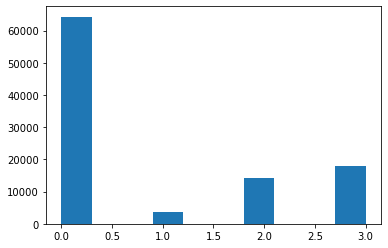

In [5]:
#训练-验证集中存在 严重的类别不平衡问题
plt.hist(data['label'], orientation = 'vertical', histtype = 'bar')
plt.show() 

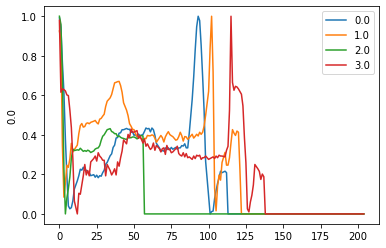

In [6]:
ids = []
cnt = 0
for id, row in data.groupby('label').apply(lambda x: x.iloc[0]).iterrows():
    ids.append(id)
    sns.lineplot(data=row[:-1])
    
    
plt.legend(ids)

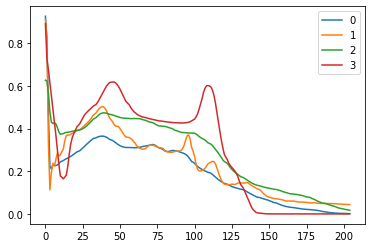

In [7]:
# 可视化每个类别的均值
np.mean(X_train_df[y_train==0]).T.plot(label='0')
np.mean(X_train_df[y_train==1]).T.plot(label='1')
np.mean(X_train_df[y_train==2]).T.plot(label='2')
np.mean(X_train_df[y_train==3]).T.plot(label='3')
plt.legend()

In [8]:
del data
gc.collect()

3571

In [9]:
X_train = X_train_df.values.reshape(-1, 205, 1)
X_test = X_test_df.values.reshape(-1, 205, 1)

In [10]:
X_train.shape

(100000, 205, 1)

In [11]:
# keras中的to_categorical 将原来类别向量中的每个值都转换为矩阵里的一个行向量，
#比如从左到右依次是0,1,2，...8个类别。2表示为[0. 0. 1. 0. 0. 0. 0. 0. 0.]，只有第3个为1，作为有效位，其余全部为0
y_train = tf.keras.utils.to_categorical(y_train, 4)

In [12]:
class Net1(tf.keras.Model):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape = (205, 1))
        self.conv2 = Conv1D(filters=32, kernel_size=3, dilation_rate=2, padding='same', activation='relu')
        self.conv3 = Conv1D(filters=64, kernel_size=3, dilation_rate=2, padding='same', activation='relu')
        self.conv4 = Conv1D(filters=64, kernel_size=5, dilation_rate=2, padding='same', activation='relu')
        self.max_pool1 = MaxPool1D(pool_size=3, strides=2, padding='same')
        
        self.conv5 = Conv1D(filters=128, kernel_size=5, dilation_rate=2, padding='same', activation='relu')
        self.conv6 = Conv1D(filters=128, kernel_size=5, dilation_rate=2, padding='same', activation='relu')
        self.max_pool2 = MaxPool1D(pool_size=3, strides=2, padding='same')
        
        self.dropout = Dropout(0.5)
        self.flatten = Flatten()
        
        self.fc1 = Dense(units=256, activation='relu')
        self.fc21 = Dense(units=16, activation='relu')
        self.fc22 = Dense(units=256, activation='sigmoid')
        self.fc3 = Dense(units=4, activation='softmax')
            
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.max_pool1(x)
        
        x = self.conv5(x)
        x = self.conv6(x) 
        x = self.max_pool2(x)
        
        x = self.dropout(x)
        x = self.flatten(x)
        
        x1 = self.fc1(x)
        x2 = self.fc22(self.fc21(x))
        x = self.fc3(x1+x2)
        
        return x 

In [13]:
# 创建模型
model = Net1()

In [14]:
# 设置优化器
model.compile(loss=tf.keras.metrics.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
# model.compile(loss=tf.keras.metrics.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

In [15]:
model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, validation_data=(X_train, y_train))

Epoch 1/30
782/782 [==============================] - 222s 284ms/step - loss: 0.1770 - mae: 0.0454 - val_loss: 0.0700 - val_mae: 0.0157
Epoch 2/30
782/782 [==============================] - 236s 302ms/step - loss: 0.0666 - mae: 0.0166 - val_loss: 0.0431 - val_mae: 0.0111
Epoch 3/30
782/782 [==============================] - 238s 304ms/step - loss: 0.0497 - mae: 0.0124 - val_loss: 0.0332 - val_mae: 0.0098
Epoch 4/30
782/782 [==============================] - 239s 305ms/step - loss: 0.0402 - mae: 0.0101 - val_loss: 0.0251 - val_mae: 0.0074
Epoch 5/30
782/782 [==============================] - 236s 301ms/step - loss: 0.0331 - mae: 0.0083 - val_loss: 0.0206 - val_mae: 0.0055
Epoch 6/30
782/782 [==============================] - 235s 301ms/step - loss: 0.0288 - mae: 0.0072 - val_loss: 0.0185 - val_mae: 0.0059
Epoch 7/30
782/782 [==============================] - 236s 302ms/step - loss: 0.0243 - mae: 0.0061 - val_loss: 0.0109 - val_mae: 0.0034
Epoch 8/30
782/782 [============================

In [16]:
y_pred = model.predict(X_test, batch_size=128)
y_pred

array([[1.00000000e+00, 7.70831627e-14, 1.53946144e-19, 6.91207218e-15],
       [1.15545873e-14, 1.24824609e-10, 1.00000000e+00, 1.57991533e-14],
       [2.31112636e-36, 2.90525725e-35, 4.31618908e-28, 1.00000000e+00],
       ...,
       [6.54996256e-06, 4.65030237e-09, 9.99993443e-01, 1.22101676e-10],
       [1.00000000e+00, 1.34128797e-08, 1.37053835e-17, 1.71425413e-16],
       [9.80708420e-01, 9.44264812e-16, 1.67499703e-08, 1.92916263e-02]],
      dtype=float32)

In [17]:
# 对结果进行评估
score = model.evaluate(X_train, y_train)
print('误差:%0.4lf' %score[0])
print('MAE:', score[1])

3125/3125 [==============================] - 59s 19ms/step - loss: 0.0020 - mae: 5.2230e-04
误差:0.0020
MAE: 0.0005222961772233248


In [18]:
y_pred = pd.get_dummies(y_pred.argmax(axis=1)).values

In [19]:
submission = pd.DataFrame({'id' : X_test_df.index,
                           'label_0' : y_pred[:, 0],
                           'label_1' : y_pred[:, 1],
                           'label_2' : y_pred[:, 2],
                           'label_3' : y_pred[:, 3],
                           })
submission.to_csv('./sumission/submission_tf.csv', index = None)